<a href="https://colab.research.google.com/github/b4wolf/NEURALNETS/blob/development/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ignore everything above

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Dataset, DataLoader
from google.colab import files
torch.manual_seed(1)

stations_data = []
stations_train = []
stations_test = []
for filename in os.listdir('.'):
  if '.csv' in filename:
    pm25_df = pd.read_csv(filename)
    pm25 = np.array(pm25_df["Value"].values)
    stations_data.append(pm25)

    train_split = int(0.8 * len(pm25))
    train_pm25, test_pm25 = pm25[:train_split], pm25[train_split:]
    normalize = lambda x: (x - train_pm25.mean(0)) / train_pm25.std(0)
    train_pm25_norm, test_pm25_norm = normalize(train_pm25), normalize(test_pm25)
    stations_train.append(train_pm25_norm)
    stations_test.append(test_pm25_norm)

print(f"Normalization Stats: mu={train_pm25.mean(0)}, std={train_pm25.std(0)}")
print(f"Train: {len(train_pm25_norm)} samples.")
print(f"Test: {len(test_pm25_norm)} samples.")
print(len(stations_data))

class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=3, batch_first=True)
        self.linear = nn.Linear(in_features=128, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = np.array([]), np.array([])
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X = np.append(X, feature)
        y = np.append(y, target)
    return torch.tensor(X, dtype=torch.float).unsqueeze(-1), torch.tensor(y, dtype=torch.float).unsqueeze(-1)


import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model(1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
epochs = 20
lookback = 7

def r2_score(predicted, target):
    mean_target = torch.mean(target)
    total_variance = torch.sum((target - mean_target)**2)
    residual_variance = torch.sum((target - predicted)**2)
    r_squared = 1 - (residual_variance / total_variance)

    return r_squared.item()

stat_train_predictions = []
stat_test_predictions = []

for i, stat in enumerate(stations_data):
  X_train, y_train = create_dataset(stations_train[i], lookback)
  X_test, y_test = create_dataset(stations_test[i], lookback)
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  for epoch in range(epochs):
    avg_train_loss = []
    avg_train_r2 = []
    avg_test_loss = []
    avg_test_r2 = []

    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        r2 = r2_score(y_pred, y_batch)
        avg_train_loss.append(loss.detach().numpy())
        avg_train_r2.append(r2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_r2 = r2_score(y_pred, y_train)

        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        test_r2 = r2_score(y_pred, y_test)

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, train_r2, test_r2))
  # final model predictions:
  model.eval()
  with torch.no_grad():
      y_pred = model(X_train)
      stat_train_predictions.append(y_pred)

      y_pred = model(X_test)
      stat_test_predictions.append(y_pred)

Normalization Stats: mu=8.747417237442923, std=6.44787155215439
Train: 7008 samples.
Test: 1752 samples.
17
Epoch 0: train RMSE 0.2623, test RMSE 0.3424, train R2 0.9311, test R2 0.8382


KeyboardInterrupt: ignored

In [17]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=3, batch_first=True)
        self.linear = nn.Linear(in_features=128, out_features=input_size)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [13]:
# from https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = np.array([]), np.array([])
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X = np.append(X, feature)
        y = np.append(y, target)
    return torch.tensor(X, dtype=torch.float).unsqueeze(-1), torch.tensor(y, dtype=torch.float).unsqueeze(-1)

In [19]:
import torch.optim as optim
import torch.utils.data as data

model = LSTM_Model(1)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
epochs = 20
lookback = 7

def r2_score(predicted, target):
    mean_target = torch.mean(target)
    total_variance = torch.sum((target - mean_target)**2)
    residual_variance = torch.sum((target - predicted)**2)
    r_squared = 1 - (residual_variance / total_variance)

    return r_squared.item()

stat_train_predictions = []
stat_test_predictions = []

for i, stat in enumerate(stations_data):
  X_train, y_train = create_dataset(stations_train[i], lookback)
  X_test, y_test = create_dataset(stations_test[i], lookback)
  loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

  for epoch in range(epochs):
    avg_train_loss = []
    avg_train_r2 = []
    avg_test_loss = []
    avg_test_r2 = []

    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)

        loss = loss_fn(y_pred, y_batch)
        r2 = r2_score(y_pred, y_batch)
        avg_train_loss.append(loss.detach().numpy())
        avg_train_r2.append(r2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_r2 = r2_score(y_pred, y_train)

        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        test_r2 = r2_score(y_pred, y_test)

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f, train R2 %.4f, test R2 %.4f" % (epoch, train_rmse, test_rmse, train_r2, test_r2))
  # final model predictions:
  model.eval()
  with torch.no_grad():
      y_pred = model(X_train)
      stat_train_predictions.append(y_pred)

      y_pred = model(X_test)
      stat_test_predictions.append(y_pred)


Epoch 0: train RMSE 0.2859, test RMSE 0.3701, train R2 0.9181, test R2 0.8110
Epoch 1: train RMSE 0.2846, test RMSE 0.3702, train R2 0.9188, test R2 0.8109
Epoch 2: train RMSE 0.2644, test RMSE 0.3441, train R2 0.9300, test R2 0.8366
Epoch 3: train RMSE 0.2928, test RMSE 0.3681, train R2 0.9141, test R2 0.8130
Epoch 4: train RMSE 0.2513, test RMSE 0.3493, train R2 0.9367, test R2 0.8317
Epoch 5: train RMSE 0.2654, test RMSE 0.3429, train R2 0.9294, test R2 0.8377
Epoch 6: train RMSE 0.2549, test RMSE 0.3437, train R2 0.9349, test R2 0.8370
Epoch 7: train RMSE 0.2554, test RMSE 0.3516, train R2 0.9346, test R2 0.8294
Epoch 8: train RMSE 0.2586, test RMSE 0.3431, train R2 0.9330, test R2 0.8375
Epoch 9: train RMSE 0.2542, test RMSE 0.3482, train R2 0.9353, test R2 0.8327
Epoch 10: train RMSE 0.2650, test RMSE 0.3433, train R2 0.9297, test R2 0.8373
Epoch 11: train RMSE 0.2601, test RMSE 0.3351, train R2 0.9322, test R2 0.8451
Epoch 12: train RMSE 0.2563, test RMSE 0.3464, train R2 0.9342

KeyboardInterrupt: ignored

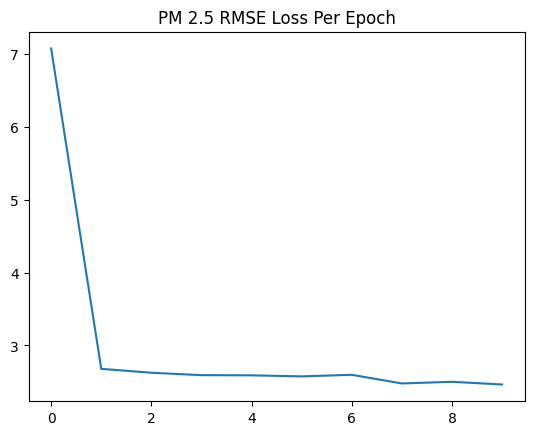

NameError: ignored

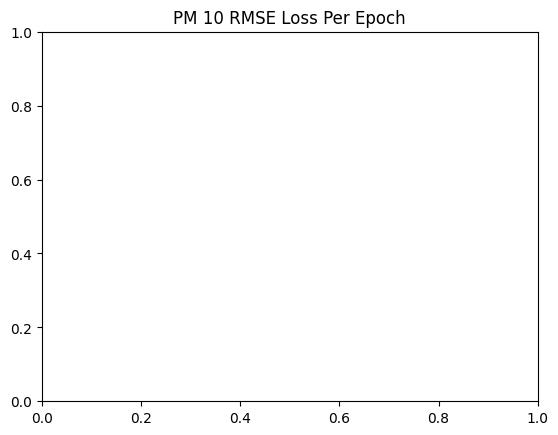

In [ ]:
plt.title("PM 2.5 RMSE Loss Per Epoch")
plt.plot(pm25_losses, label="pm25 loss")
plt.show()
plt.title("PM 10 RMSE Loss Per Epoch")
plt.plot(pm10_losses, label="pm10 loss")
plt.show()
plt.title("SO2 RMSE Loss Per Epoch")
plt.plot(so2_losses, label="so2 loss")
plt.show()

In [22]:
def plot(model, timeseries, train_predictions, test_predictions):
  with torch.no_grad():
      # shift train predictions for plotting
      train_plot = np.ones_like(timeseries[:,0]) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1, 0]
      train_plot[lookback:len(train_predictions)] = y_pred
      # shift test predictions for plotting
      y_pred = model(X_test)
      y_pred = y_pred[:, -1, 0]
      test_plot = np.ones_like(timeseries[:,0]) * np.nan
      test_plot[train_size+lookback:len(timeseries[:,0])] = y_pred
  # plot
  plt.plot(timeseries[:,0], c='b')
  plt.show()
  plt.plot(train_plot, c='r')
  plt.plot(test_plot, c='g')
  #plt.xlim(7250, 7750)
  plt.show()